In [1]:
import keras 
import tensorflow as tf
import keras.backend.tensorflow_backend as K
from PIL import Image
from imutils import paths
from os import path
from keras.optimizers import Adam,RMSprop
import pandas as pd
keras.__version__
IMAGE_DIMS = (350,250,3)
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [2]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array

In [3]:
date_arr = np.load('./new_date_arr.npy',allow_pickle=True)
dust_arr = np.load('./result_arr_avg_7.npy',allow_pickle=True)
wind_arr = np.load('./wind_arr.npy',allow_pickle=True)
humi_arr = np.load('./humi_arr.npy',allow_pickle=True)

In [4]:
import time

start = time.time() 
imagePaths = sorted(list(paths.list_images('./dataset/image')))
image_arr = []

for i in imagePaths:
    img_name = int(path.splitext(path.basename(i))[0])
    
    if img_name in date_arr :
        image = Image.open(i)
        image = image.resize((IMAGE_DIMS[0],IMAGE_DIMS[1]))
        image = img_to_array(image)
        image_arr.append(image)
        
image_arr = np.array(image_arr, dtype="float") / 255.0        
print("[INFO] data matrix: {} images ({:.2f}MB)".format(len(imagePaths), image_arr.nbytes / (1024 * 1000.0)))

[INFO] data matrix: 18126 images (22940.04MB)


In [5]:
from sklearn.utils import shuffle



con_data_img = image_arr
con_data_val = dust_arr

print(wind_arr.shape)
con_data_wea = np.concatenate([wind_arr.reshape(len(wind_arr),1),humi_arr.reshape(len(humi_arr),1)], axis=1)


# 국내는 PM2.5이 16이상이면 보통
# for i in range(0,dustvalue.shape[0]):
#     if int(dustvalue[i]) > 0 :
#         con_data_img.append(data[i])
#         con_data_val.append(dustvalue[i])
#         con_data_wea.append(add_info[i])
        
# con_data_img, con_data_val, con_data_wea = shuffle(np.array(con_data_img), np.array(con_data_val), np.array(con_data_wea), random_state=0)
# con_data_img = np.array(con_data_img)
# con_data_val = np.array(con_data_val)
# con_data_wea = np.array(con_data_wea)

num = int(con_data_img.shape[0]*0.8)

train_img = con_data_img[:num]
train_val = con_data_val[:num]
train_wea = con_data_wea[:num]

test_img = con_data_img[num:]
test_val = con_data_val[num:]
test_wea = con_data_wea[num:]

print(con_data_img.shape)
print(train_img.shape)
print(test_img.shape)


(11186,)
(11186, 250, 350, 3)
(8948, 250, 350, 3)
(2238, 250, 350, 3)


In [6]:
# import the necessary packages
from keras.models import Model, Sequential
from keras.layers import Input, LSTM, GRU, Embedding
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K

chanDim=-1
model = Sequential()

# CONV => RELU => POOL
model.add(Conv2D(32, (3, 3), padding="same",input_shape=(IMAGE_DIMS[1], IMAGE_DIMS[0],3)))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

# (CONV => RELU) * 2 => POOL
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# (CONV => RELU) * 2 => POOL
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(256, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())


image_input = Input(shape=(IMAGE_DIMS[1], IMAGE_DIMS[0],3))
encoded_image = model(image_input)

# 다음은 문제를 벡터로 인코딩할 숫자 모델을 정의합니다
numeric_input = Input(shape=(2,))
embedded_numeric = Embedding(input_dim=100, output_dim=256, input_length=2)(numeric_input)

# numeric_input2 = Dense(256, activation="linear")(embedded_numeric)
# print(embedded_numeric.shape)

#numeric_input2 = GRU(256)(embedded_numeric)
numeric_input2 = GRU(256)(embedded_numeric)
# print(numeric_input2.shape)


# numeric_input = Input(shape=(8,), dtype='float32')
# numeric_input1 = Dense(1000,activation='linear')(numeric_input)
# numeric_input2 = Dense(100,activation='linear')(numeric_input1)

# 질문 벡터와 이미지 벡터를 연결해 봅시다:
merged = keras.layers.concatenate([encoded_image, numeric_input2],axis=-1)

output = Dense(1)(merged)

# 그리고 상층의 로지스틱 회귀를 수치에 대해 학습시킵니다:
# output = Dense(1024, activation='softmax')(merged)
# output = Dense(128, activation='softmax')(output)
# output = Dense(1)(output)
# 다음은 최종 모델입니다:
model = Model(inputs=[image_input, numeric_input], outputs=output)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [7]:
#opt = RMSprop(lr=0.005, rho=0.9, epsilon=None, decay=0.0)
opt = Adam(lr=0.002, epsilon=None, decay=0.0)
model.compile(loss="mse", optimizer=opt,metrics=["accuracy"])
# logcosh, mes, 
H = model.fit([train_img,train_wea], train_val ,batch_size=10, epochs=200)


print("[INFO] serializing network...")
model.save('new-LSTM-adam.model')



Instructions for updating:
Use tf.cast instead.
Epoch 1/200
8948/8948 [==============================] - 35s 4ms/step - loss: 244.3261 - acc: 0.0067
Epoch 2/200
8948/8948 [==============================] - 33s 4ms/step - loss: 165.4432 - acc: 0.0084
Epoch 3/200
8948/8948 [==============================] - 33s 4ms/step - loss: 126.2024 - acc: 0.0105
Epoch 4/200
8948/8948 [==============================] - 33s 4ms/step - loss: 104.3586 - acc: 0.0113
Epoch 5/200
8948/8948 [==============================] - 33s 4ms/step - loss: 92.9719 - acc: 0.0117
Epoch 6/200
8948/8948 [==============================] - 33s 4ms/step - loss: 77.3497 - acc: 0.0131
Epoch 7/200
8948/8948 [==============================] - 33s 4ms/step - loss: 72.9745 - acc: 0.0134
Epoch 8/200
8948/8948 [==============================] - 33s 4ms/step - loss: 67.2029 - acc: 0.0145
Epoch 9/200
8948/8948 [==============================] - 33s 4ms/step - loss: 60.9029 - acc: 0.0150
Epoch 10/200
8948/8948 [========================

8948/8948 [==============================] - 32s 4ms/step - loss: 5.5966 - acc: 0.0360
Epoch 80/200
8948/8948 [==============================] - 33s 4ms/step - loss: 5.9338 - acc: 0.0335
Epoch 81/200
8948/8948 [==============================] - 33s 4ms/step - loss: 5.2406 - acc: 0.0343
Epoch 82/200
8948/8948 [==============================] - 33s 4ms/step - loss: 6.0144 - acc: 0.0363
Epoch 83/200
8948/8948 [==============================] - 33s 4ms/step - loss: 6.5583 - acc: 0.0336
Epoch 84/200
8948/8948 [==============================] - 33s 4ms/step - loss: 5.7941 - acc: 0.0399
Epoch 85/200
8948/8948 [==============================] - 33s 4ms/step - loss: 4.6997 - acc: 0.0354
Epoch 86/200
8948/8948 [==============================] - 33s 4ms/step - loss: 6.7431 - acc: 0.0367
Epoch 87/200
8948/8948 [==============================] - 33s 4ms/step - loss: 5.8572 - acc: 0.0371
Epoch 88/200
8948/8948 [==============================] - 33s 4ms/step - loss: 4.4796 - acc: 0.0419
Epoch 89/200


8948/8948 [==============================] - 33s 4ms/step - loss: 3.9165 - acc: 0.0435
Epoch 161/200
8948/8948 [==============================] - 33s 4ms/step - loss: 3.1166 - acc: 0.0467
Epoch 162/200
8948/8948 [==============================] - 33s 4ms/step - loss: 3.1320 - acc: 0.0476
Epoch 163/200
8948/8948 [==============================] - 33s 4ms/step - loss: 3.4232 - acc: 0.0481
Epoch 164/200
8948/8948 [==============================] - 33s 4ms/step - loss: 3.6541 - acc: 0.0481
Epoch 165/200
8948/8948 [==============================] - 33s 4ms/step - loss: 3.8041 - acc: 0.0464
Epoch 166/200
8948/8948 [==============================] - 33s 4ms/step - loss: 3.8748 - acc: 0.0488
Epoch 167/200
8948/8948 [==============================] - 33s 4ms/step - loss: 3.0011 - acc: 0.0493
Epoch 168/200
8948/8948 [==============================] - 33s 4ms/step - loss: 2.9421 - acc: 0.0524
Epoch 169/200
8948/8948 [==============================] - 33s 4ms/step - loss: 3.5177 - acc: 0.0467
Epoc

In [8]:
print(image_arr.shape)
print(dust_arr.shape)

print(wind_arr.shape)
print(humi_arr.shape)

print(test_img.shape)
print(test_wea.shape)

print(model.predict([test_img, test_wea]))

y_pred = np.squeeze(np.round(model.predict([test_img, test_wea]).astype(np.int64)))

print(test_val.shape)
print(y_pred.shape)

print(np.round(test_val.astype(np.int64)))
print(y_pred)

(11186, 250, 350, 3)
(11186,)
(11186,)
(11186,)
(2238, 250, 350, 3)
(2238, 2)
[[44.210358 ]
 [42.493183 ]
 [46.260468 ]
 ...
 [ 5.2337265]
 [ 6.507616 ]
 [ 7.703509 ]]
(2238,)
(2238,)
[52 55 55 ...  3  4  4]
[44 42 46 ...  5  6  7]


In [9]:
RMSE = mean_squared_error(test_val.astype(np.int64), y_pred)**0.5
R2SCORE = r2_score(test_val.astype(np.int64), y_pred)

print("RMSE 는 : " , RMSE)
print("R2SCORE 는 : ", R2SCORE)

RMSE 는 :  32.734777892115176
R2SCORE 는 :  -0.00676177988958182


Text(70, 50, 'R-squared = -0.01')

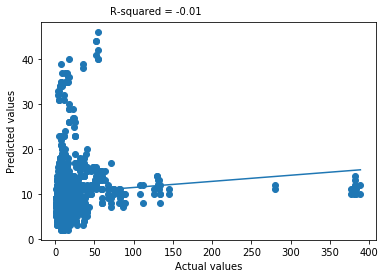

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

test_val=np.squeeze(test_val.astype(np.int64))

plt.scatter(test_val,y_pred)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')

plt.plot(np.unique(test_val), np.poly1d(np.polyfit(test_val, y_pred, 1))(np.unique(test_val)))

plt.text(70, 50, 'R-squared = %0.2f' % R2SCORE)

In [11]:
np.round(test_val.astype(np.int64))


array([52, 55, 55, ...,  3,  4,  4], dtype=int64)

In [12]:
y_pred

array([44, 42, 46, ...,  5,  6,  7], dtype=int64)